In [125]:
import celligner
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as patches

from taigapy import TaigaClient
tc = TaigaClient()

## Exploring Celligner output
### Load Celligner model

In [126]:
my_celligner = celligner.Celligner()

In [127]:
my_celligner.load("../bdekegel/data/celligner_output/model_22q2_public.pkl")

### Load sample annotations

In [128]:
model_ann = tc.get(name='internal-22q2-097a', version=18, file='Model')
model_ann = model_ann.set_index('ModelID')[['OncotreeLineage','OncotreeCode']]\
                     .rename(columns={'OncotreeLineage':'tissue_type','OncotreeCode':'oncotree_code'})\
                     .assign(sample_type='DepMap model')

tumor_ann = tc.get(name='celligner-input-9827', version=7, file='tumor_annotations')
tumor_ann = tumor_ann.set_index('sampleID')[['oncotree_lineage','oncotree_code']]\
                     .rename(columns={'oncotree_lineage':'tissue_type'})\
                     .assign(sample_type='TCGA+ tumor')

annots = pd.concat([model_ann, tumor_ann])
annots[:1]

,tissue_type,oncotree_code,sample_type
ACH-000001,Ovary/Fallopian Tube,HGSOC,DepMap model


### Add annotations to UMAP dataframe

In [167]:
# Try out different UMAP embeddings by running the following with different seeds
# Looking at several UMAPs provides a better indication of the main clusters / relationship between clusters
my_celligner.computeMetricsForOutput(UMAP_only=True, umap_rand_seed=14)

Computing UMAP embedding...


In [168]:
output = my_celligner.umap_reduced#.assign(cluster = my_celligner.output_clusters)
output = pd.merge(output.reset_index(), annots.reset_index()).rename(columns={'index':'model_id'})

# Don't use rare tissue labels
output = output.replace({'tissue_type': {'Muscle':'Other/Unknown','Other':'Other/Unknown','Hair':'Other/Unknown',
                                         'Unknown':'Other/Unknown'}})

In [169]:
output[:1]

,model_id,umap1,umap2,tissue_type,oncotree_code,sample_type
0,TH27_1241_S01,8.468274,14.236962,CNS/Brain,None,TCGA+ tumor


### Draw UMAP

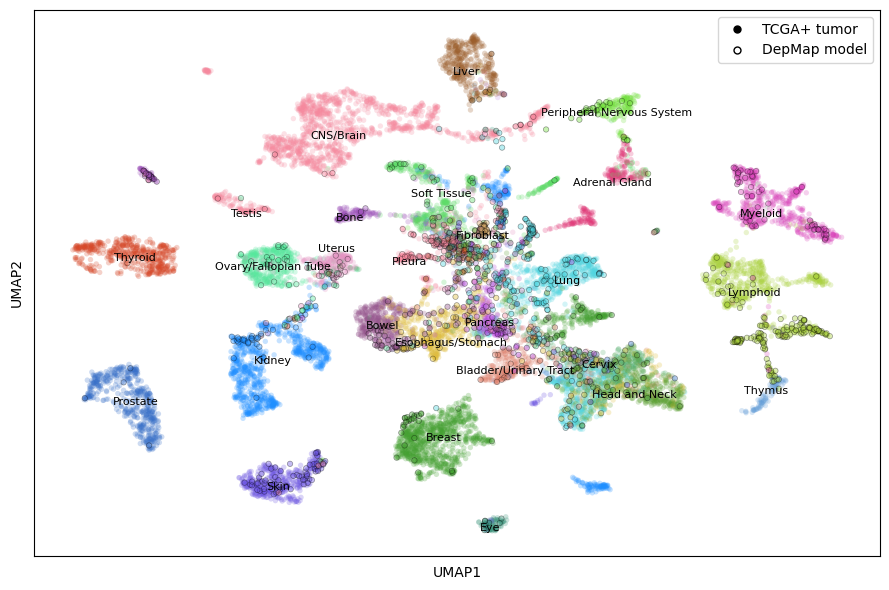

In [179]:
f, ax = plt.subplots(1, 1, figsize=(9,6))

sns.scatterplot(output[output.sample_type=='TCGA+ tumor'], x='umap1', y='umap2', hue='tissue_type', 
                alpha=0.25, linewidth=0, ax=ax, s=15, palette=celligner.params.TISSUE_COLOR_OT,)
sns.scatterplot(output[output.sample_type=='DepMap model'], x='umap1', y='umap2', hue='tissue_type', 
                alpha=0.4, linewidth=0.5, edgecolor='black', ax=ax, s=15, palette=celligner.params.TISSUE_COLOR_OT)

ax.get_yaxis().set_ticks([]); ax.get_xaxis().set_ticks([])
ax.set_xlabel('UMAP1'); ax.set_ylabel('UMAP2')

legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='k', markersize=5,
                          label='TCGA+ tumor', markeredgecolor='k'),
                   Line2D([0], [0], marker='o', color='w', label='DepMap model', 
                          markerfacecolor='w', markersize=5, markeredgecolor='k')]
ax.legend(handles=legend_elements)

tissue_means = output.groupby('tissue_type').agg({'umap1':'median', 'umap2':'median'})
n = output.groupby('tissue_type').model_id.count()
for t in tissue_means.loc[tissue_means.index.isin(n[n>20].index) & (tissue_means.index!='Biliary Tract')].iterrows():
    # Shifting labels to make them easier to read
    if t[0] in ['Esophagus/Stomach']:
        ax.text(t[1].umap1, t[1].umap2-1, t[0], ha='center', va='bottom', fontsize=8)
    elif t[0] in ['Uterus','Lung']:
        ax.text(t[1].umap1, t[1].umap2+.5, t[0], ha='center', va='bottom', fontsize=8)
    else:
        ax.text(t[1].umap1, t[1].umap2, t[0], ha='center', va='top', fontsize=8)
plt.tight_layout()
f.savefig("../bdekegel/figures/celligner_public22q2.png", bbox_inches="tight", dpi=300)

### Model - tumor distances
Euclidean distances between tumor samples and cell line samples in the combined 70 principal components. Computing correlation with previous distances as a QC step.

In [153]:
# This is what is currently displayed in the public portal
prev_dist = tc.get(name='celligner-output-f163', version=27, file='tumor_CL_distances')

In [154]:
CCLE_annot = tc.get(name='internal-21q3-fe4c', version=16, file='sample_info')

In [155]:
new_dist = pd.merge(my_celligner.tumor_CL_dist.T.reset_index().rename(columns={'index':'DepMap_ID'}), 
                    CCLE_annot[['DepMap_ID','CCLE_Name']])\
              .set_index('CCLE_Name').drop(columns=['DepMap_ID']).T
new_dist = new_dist.loc[:, new_dist.columns.isin(prev_dist.columns)]
prev_dist = prev_dist.loc[:, prev_dist.columns.isin(new_dist.columns)]

Median correlation: 0.888


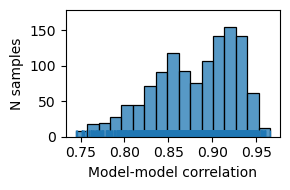

In [156]:
dist_corr = new_dist.corrwith(prev_dist)
print('Median correlation: %.3f' % (dist_corr.median()))
fig, ax = plt.subplots(1, 1, figsize=(3, 2))
sns.histplot(dist_corr, ax=ax); sns.rugplot(dist_corr, ax=ax, height=0.05); 
ax.set_xlabel('Model-model correlation'); ax.set_ylabel('N samples');
plt.tight_layout();

Median correlation: 0.961


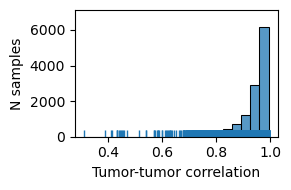

In [157]:
dist_corr = new_dist.corrwith(prev_dist, axis=1)
print('Median correlation: %.3f' % (dist_corr.median()))
fig, ax = plt.subplots(1, 1, figsize=(3, 2))
sns.histplot(dist_corr, bins=20, ax=ax); sns.rugplot(dist_corr, ax=ax, height=0.05); 
ax.set_xlabel('Tumor-tumor correlation'); ax.set_ylabel('N samples');
plt.tight_layout();